<a href="https://colab.research.google.com/github/cl3789/machine-learning-basics/blob/main/CNN_with_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@markdown import library

import pandas as pd
import numpy as np
from numpy.random import seed
import csv
from scipy.io.arff import loadarff 

import tensorflow
from tensorflow import keras
from tensorflow.keras import layers


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
import sklearn.datasets

# from nltk import word_tokenize, pos_tag
# from nltk.stem import WordNetLemmatizer
# from nltk.corpus import wordnet
# import nltk
# nltk.download('punkt')
# from nltk import word_tokenize, pos_tag
# from nltk.stem import WordNetLemmatizer
# import re
# from nltk.corpus import wordnet
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, KFold, cross_val_score,cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

from keras.preprocessing.text import Tokenizer
from keras.wrappers.scikit_learn import KerasClassifier
from keras_preprocessing.sequence import pad_sequences



In [ ]:
#@markdown Set random seed
seed(1)
tensorflow.random.set_seed(1)

# Utility function for model training and plots

In [ ]:
#@markdown show details
def plot_gallery(title, images, image_shape, n_col, n_row, cmap="gray"):
    ## Input array "Images" is 2-dimensional.
    fig, axs = plt.subplots(
        nrows=n_row,
        ncols=n_col,
        figsize=(1.0 * n_col, 1.3 * n_row),
        facecolor="white",
        constrained_layout=True,
    )
    fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.1, hspace=0, wspace=0)
    fig.set_edgecolor("black")
    fig.suptitle(title, size=16)
    for ax, img_vect in zip(axs.flat, images):
        vmax = max(img_vect.max(), -img_vect.min())
        im = ax.imshow(
            img_vect.reshape(image_shape),
            cmap=cmap,
            #interpolation="nearest",
            vmin=-vmax,
            vmax=vmax,
        )
        ax.axis("off")

    plt.show()
    

def plot_conf_matrix(ground_truth, prediction, classes):
  conf_mat = confusion_matrix(ground_truth, prediction)
  conf_mat = np.divide(conf_mat, conf_mat.sum(axis = 1))
  conf_mat_plot = sns.heatmap(conf_mat, linewidths=.5, cmap="GnBu", square=True,
                             xticklabels=classes, yticklabels=classes, vmax = 1)
  plt.title("Classification accuracy")

def model_train(model, x_train, y_train, num_epoch, batch_size, x_val=None, y_val=None):  
  if x_val is None:
    ## Automatically choose 20% data from x_train as validation
    history = model.fit(x_train, y_train, 
                        epochs=num_epoch, batch_size=batch_size, 
                        verbose=1, validation_split=0.2)
  else:
    print("Please input validation data")
    history = model.fit(x_train, y_train,
                        epochs=num_epoch, batch_size=batch_size,
                        verbose=1, 
                        validation_data=(x_val, y_val))

  #print(history.history.keys())
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.xticks(np.arange(0, num_epoch+1, 1))
  plt.show()

def create_mlp_word_model(vectorize_format, num_class, mlp_structure, dropout_rate, vocab_size, embedding_dim, maxlen):
  """Create customized MLP model"""
  model = keras.Sequential()
  if vectorize_format == "sequence":
    model.add(layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim, 
                              input_length=maxlen, trainable=True))
    model.add(layers.GlobalMaxPooling1D())

  else:
    model.add(keras.Input(shape=(num_words, )))
  
  for n_units in mlp_structure:
    model.add(layers.Dense(n_units, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
  
  model.add(layers.Dense(num_class, activation='softmax'))

  model.compile(loss='categorical_crossentropy', 
                optimizer='adam', metrics=['accuracy'])
  return model

def param_tunning_mlp(param_grid, create_model, 
                      X_train, y_train,
                      X_test, y_test,
                      epochs, batch_size): 
  """Grid Search with cross-validation for Keras MLP models"""
  folds = KFold(n_splits = 3, shuffle = True, random_state = 1)
  model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=batch_size,
                            verbose=3)
  grid = GridSearchCV(estimator=model, param_grid=param_grid,
                            cv=folds, verbose=3,error_score="raise",
                            return_train_score=True)
  grid_result = grid.fit(X_train, y_train)

  print("Mean cross-validated score of the best_estimator:", grid_result.best_score_)
  print("Best params:", grid_result.best_params_)
            
  # Evaluate testing set
  test_accuracy = grid.score(X_test, y_test)
  print("Test accuracy:", test_accuracy)
  return grid_result

# Fashion MNIST

Codes are partially adapted from: https://keras.io/examples/vision/mnist_convnet/#train-the-model

In [ ]:
## loading datasets
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [ ]:
fmnist_classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
                  "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

fmnist_num_classes = len(fmnist_classes)

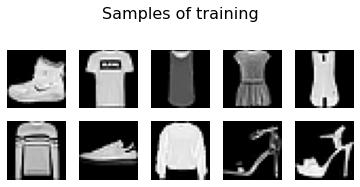

Corresponding labels:
Ankle boot
T-shirt/top
T-shirt/top
Dress
T-shirt/top
Pullover
Sneaker
Pullover
Sandal
Sandal


In [ ]:
#@markdown Show some examples in the training
plot_gallery("Samples of training", x_train[:10], (28,28),5, 2)
print("Corresponding labels:")
for i in y_train[:10]:
  print(fmnist_classes[i])

In [ ]:
#@markdown Preprocess data

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to one-hot vectors
y_train_onehot = keras.utils.to_categorical(y_train, fmnist_num_classes)
y_test_onehot = keras.utils.to_categorical(y_test, fmnist_num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


**Implement MLP**

In [ ]:
## Flatten the image into a long feature vector
feature_vector_length = 28*28*1
x_train_flat = x_train.reshape(x_train.shape[0], feature_vector_length)
x_test_flat  = x_test.reshape(x_test.shape[0], feature_vector_length)

In [ ]:
mlp_model = keras.Sequential(
    [
        keras.Input(shape=feature_vector_length), ## define input layer 
        layers.Dense(300, activation='relu'),     ## define first hidden layer
        layers.Dense(50, activation='relu'),      ## define second hidden layer
        layers.Dense(fmnist_num_classes, activation='softmax'), ## define output layer
    ]
) 

## Compile the model, while defining the loss function, optimizer, evaluation metrics, etc 
mlp_model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])
mlp_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 300)               235500    
                                                                 
 dense_4 (Dense)             (None, 50)                15050     
                                                                 
 dense_5 (Dense)             (None, 10)                510       
                                                                 
Total params: 251,060
Trainable params: 251,060
Non-trainable params: 0
_________________________________________________________________


Epoch 1/2
192/192 [==============================] - 2s 5ms/step - loss: 0.5783 - accuracy: 0.7997 - val_loss: 0.4404 - val_accuracy: 0.8458
Epoch 2/2
192/192 [==============================] - 1s 4ms/step - loss: 0.3988 - accuracy: 0.8589 - val_loss: 0.4150 - val_accuracy: 0.8525


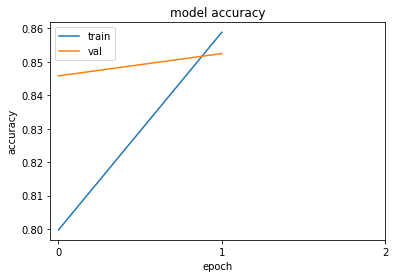

In [ ]:
# Configure the model and start training
num_epoch = 2 # you can increase the number of training epochs
batch_size = 250
model_train(mlp_model,x_train_flat, y_train_onehot, num_epoch,batch_size)

MLP Test loss: 0.43770238757133484
MLP Test accuracy: 0.8424000144004822
313/313 [==============================] - 1s 2ms/step


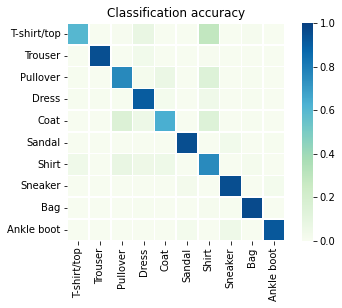

In [ ]:
#@markdown Evaluate the trained MLP model on the test dataset
score_mlp = mlp_model.evaluate(x_test_flat, y_test_onehot, verbose=0)
print("MLP Test loss:", score_mlp[0])
print("MLP Test accuracy:", score_mlp[1])

x_test_pred = mlp_model.predict(x_test_flat)
x_test_pred = x_test_pred.argmax(1)

plot_conf_matrix(y_test, x_test_pred, fmnist_classes)

**Implement CNN**

In [ ]:
input_shape = (28,28,1)
cnn_model = keras.Sequential(
    [
        keras.Input(shape=input_shape),  ## define input layer 
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"), ## first 2d-convolution layer, with 32 filters
        layers.MaxPooling2D(pool_size=(2, 2)), ## first max pooling layer
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"), ## second 2d-convolution layer, with 64 filters
        layers.MaxPooling2D(pool_size=(2, 2)), ## second max pooling layer
        layers.Flatten(), ## Flatten the feature maps
        layers.Dropout(0.5), ## Drop 50% of units, which helps prevent overfitting.
        layers.Dense(fmnist_num_classes, activation="softmax"), ## output layer
    ]
)

cnn_model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)             

Epoch 1/2
192/192 [==============================] - 4s 8ms/step - loss: 0.8353 - accuracy: 0.7063 - val_loss: 0.5011 - val_accuracy: 0.8208
Epoch 2/2
192/192 [==============================] - 1s 7ms/step - loss: 0.4951 - accuracy: 0.8211 - val_loss: 0.4195 - val_accuracy: 0.8551


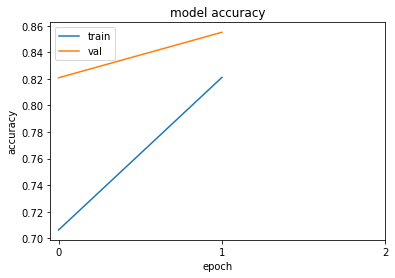

In [ ]:
# Configure the model and start training CNN
num_epoch = 2
batch_size = 250
model_train(cnn_model, x_train, y_train_onehot, num_epoch, batch_size)

CNN Test loss: 0.43386006355285645
CNN Test accuracy: 0.8495000004768372
313/313 [==============================] - 1s 2ms/step


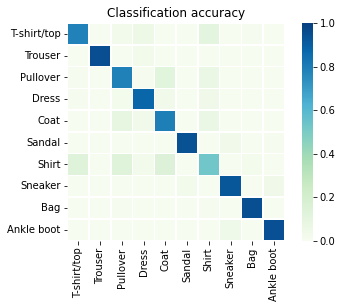

In [ ]:
#@markdown Evaluate the trained CNN model
score_cnn = cnn_model.evaluate(x_test, y_test_onehot, verbose=0)
print("CNN Test loss:", score_cnn[0])
print("CNN Test accuracy:", score_cnn[1])

x_test_pred_cnn = cnn_model.predict(x_test)
x_test_pred_cnn = x_test_pred_cnn.argmax(1)

plot_conf_matrix(y_test, x_test_pred_cnn, fmnist_classes)

# News20

In [ ]:
news20_train = fetch_20newsgroups(subset="train")
news20_train_features = news20_train.data #training set feature
news20_train_labels = news20_train.target #training set label

In [ ]:
news20_test = fetch_20newsgroups(subset="test")
news20_test_features = news20_test.data #test set feature
news20_test_labels = news20_test.target #test set label

In [ ]:
news20_classes = news20_train.target_names
news20_num_classes = len(news20_classes) # number of classes

# convert class vectors to one-hot vectors
y_train_news_onehot = keras.utils.to_categorical(news20_train_labels, news20_num_classes)
y_test_news_onehot = keras.utils.to_categorical(news20_test_labels, news20_num_classes)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(news20_train_features, y_train_news_onehot,
                                                    test_size=0.2, ## use 20% data for test
                                                    random_state=42, ## set random state for replication of experiment
                                                    stratify=y_train_news_onehot ## stratify data instances based on their labels
                                                    )   


In [ ]:
X_train[0]

"From: karenb@westford.ccur.com (Karen Bircsak)\nSubject: lost in (TekHVC color) space\nArticle-I.D.: westford.1993Apr6.160748.3794\nOrganization: Concurrent Computer Corp.  Westford, MA\nLines: 33\n\n(please respond via email!)\n\nHas anybody actually seen the Tek color space stuff working?  I'm not\nhaving any luck with either the xtici editor from export.lcs.mit.edu or with\nO'Reilly's ftp-able example xcms from ftp.uu.net.\n\nThe O'Reilly example fails for almost every set of inputs because\nXcmsTekHVCQueryMaxV returns a smaller value than XcmsTekHVCQueryMinV does\n(which makes no sense to me).\n\nThe xtici editor fails in XcmsStoreColors, apparently because the\nmathematical manipulations of the color specs results in invalid values.  So\nyou can't actually edit any colors.\n\nWe have X11 R5 patch level 22; 8-bit pseudoColor visual.  I've poked around \nin the xcms code in Xlib, but without some understanding of the theory I have \nno idea what's going wrong.  Can somebody confirm

**Create a base line model**

In [ ]:
## Tokenize words
num_words = 5000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

## Transforms each text in texts to a sequence of integers.
# maxlen = 100 # can be modified. Length of input sequences. 
# X_train = tokenizer.texts_to_sequences(X_train) 
# X_val = tokenizer.texts_to_sequences(X_val)
# X_test = tokenizer.texts_to_sequences(news20_test_features) 

## Pad the sequence of each data point to same dimension
# X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
# X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)
# X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)



## Vectorize the tokens with tfidf transformation
X_train = tokenizer.texts_to_matrix(X_train, mode="tfidf") 
X_val = tokenizer.texts_to_matrix(X_val,  mode="tfidf")
X_test = tokenizer.texts_to_matrix(news20_test_features,  mode="tfidf") 

print("Train data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)


Train data shape: (9051, 5000)
Validation data shape: (2263, 5000)


**Create a Baseline MLP model**

*Why is my training loss much higher than my testing loss?*
A Keras model has two modes: training and testing. Regularization mechanisms, such as Dropout and L1/L2 weight regularization, are turned off at testing time. They are reflected in the training time loss but not in the test time loss.

Besides, the training loss that Keras displays is the average of the losses for each batch of training data, over the current epoch. Because your model is changing over time, the loss over the first batches of an epoch is generally higher than over the last batches. This can bring the epoch-wise average down. On the other hand, the testing loss for an epoch is computed using the model as it is at the end of the epoch, resulting in a lower loss.

Check out: https://keras.io/getting_started/faq/

In [ ]:
vocab_size = len(tokenizer.word_index) + 1  # used in sequence encoding. Adding again 1 because of reserved 0 index
print(vocab_size)
maxlen = 100 # used in sequence encoding, indicating length of input sequences. value can be modified. 
embedding_dim = 600 # used in sequence encoding, indicating dimension of the dense embedding.

mlp_structure = [512, 256, 128] # define the number of units in each layer
dropout_rate = 0.2 # dropout rate after each Dense layer

## Creat the baseline model
baseline = create_mlp_word_model(vectorize_format = "tfidf",
                                 num_class=news20_num_classes, 
                                 mlp_structure = mlp_structure,
                                 dropout_rate = dropout_rate,
                                 vocab_size=None, 
                                 embedding_dim=None, 
                                 maxlen=None)
baseline.summary()

119286
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 512)               2560512   
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                                 
 dense_17 (Dense)            (None, 256)               131328    
                                                                 
 dropout_13 (Dropout)        (None, 256)               0         
                                                                 
 dense_18 (Dense)            (None, 128)               32896     
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 20)        

Please input validation data
Epoch 1/10
91/91 [==============================] - 1s 11ms/step - loss: 1.6276 - accuracy: 0.5479 - val_loss: 0.6192 - val_accuracy: 0.8374
Epoch 2/10
91/91 [==============================] - 1s 7ms/step - loss: 0.3805 - accuracy: 0.9006 - val_loss: 0.5177 - val_accuracy: 0.8599
Epoch 3/10
91/91 [==============================] - 0s 5ms/step - loss: 0.1625 - accuracy: 0.9661 - val_loss: 0.5459 - val_accuracy: 0.8595
Epoch 4/10
91/91 [==============================] - 0s 5ms/step - loss: 0.0848 - accuracy: 0.9827 - val_loss: 0.5662 - val_accuracy: 0.8608
Epoch 5/10
91/91 [==============================] - 1s 6ms/step - loss: 0.0577 - accuracy: 0.9895 - val_loss: 0.6662 - val_accuracy: 0.8555
Epoch 6/10
91/91 [==============================] - 0s 5ms/step - loss: 0.0964 - accuracy: 0.9885 - val_loss: 0.7386 - val_accuracy: 0.8621
Epoch 7/10
91/91 [==============================] - 1s 6ms/step - loss: 0.0779 - accuracy: 0.9894 - val_loss: 0.7165 - val_accurac

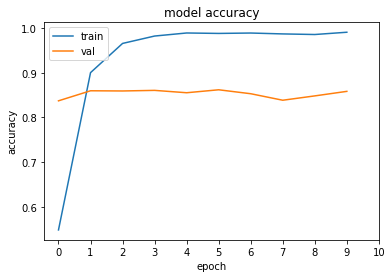

In [ ]:
## Train baseline model
model_train(baseline, X_train, y_train, num_epoch=10, batch_size=100, 
            x_val=X_val, y_val= y_val)

In [ ]:
score_baseline = baseline.evaluate(X_test, y_test_news_onehot, verbose=0)
print("Baseline MLP Test loss:", score_baseline[0])
print("Baseline MLP Test accuracy:", score_baseline[1])

Baseline MLP Test loss: 1.2235838174819946
Baseline MLP Test accuracy: 0.7823951244354248


In [ ]:
## Define the searching space
param_grid = dict(vectorize_format = ["tfidf"],
                  mlp_structure = [[300,200,100], [100,100,100]], 
                  dropout_rate = [0.1, 0.2],
                  num_class=[news20_num_classes],
                  vocab_size = [None],
                  maxlen=[None],
                  embedding_dim=[None],
                  )

print(param_grid)


## Run GridSearchCV in desired datasets
grid_result = param_tunning_mlp(param_grid, create_mlp_word_model, 
                      X_train, y_train, ## could be changed to other training dataset
                      X_val, y_val, ## could be changed to other validation or test dataset
                      epochs=10, batch_size=100)

{'vectorize_format': ['tfidf'], 'mlp_structure': [[300, 200, 100], [100, 100, 100]], 'dropout_rate': [0.1, 0.2], 'num_class': [20], 'vocab_size': [None], 'maxlen': [None], 'embedding_dim': [None]}
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
[CV 1/3] END dropout_rate=0.1, embedding_dim=None, maxlen=None, mlp_structure=[300, 200, 100], num_class=20, vectorize_format=tfidf, vocab_size=None;, score=(train=0.999, test=0.857) total time=   4.0s
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
[CV 2/3] END dropout_rate=0.1, embedding_dim=None, maxlen=None, mlp_structure=[300, 200, 100], num_class=20, vectorize_format=tfidf, vocab_size=None;, score=(train=0.999, test=0.853) total time=   3.6s
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
[CV 3/3] END dropout_rate=0.1, embedding_dim=None, maxlen=None, mlp_structure=[300, 200, 100], num_class=20, vectorize_format=tfidf, vocab_size=None;, score=(train=1.000, test=0.862) total time=   3.0s
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 